<a href="https://colab.research.google.com/github/Tillmawitz/data_602/blob/main/Tillmawitz_602_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstract

As the effects of climate change begin to manifest in measurable ways it is increasingly important to consider whether and to what extent regional trends manifest at local levels in key geographies. Snowpack levels in the Upper Colorado River Basin have fallen by 23% over the past 30 years, with precipitation levels falling to a slightly lesser extent (Bolinger et. al, 2024). Tracking these macro trends is useful for communities far downstream when assessing risks to their water supply; however, communities near the headwaters have much more localized water sources. The Denver metro area gathers water from three major river basins located in or near the city, with the majority coming from the Blue River Basin which is itself a tributary of the Colorado River (Adams, 2021). In this study we explore snowfall trends in the Blue River Basin to determine to what extent the regional trends are reflected in this critically important basin. Records come from seven weather stations located in or near the basin and stretch back to the late 1800s. By aggregating the records to find average snowfall levels over the basin then using an STL decomposition to remove the seasonal component of the data we determine the snowfall trend in the Blue River Basin has been flat over the period of record, indicating the basin is not following the trend of the macro region. This finding demonstrates the importance of localized analysis of larger trends when attempting to plan for the consequences expected from our changing climate. Failure to do so could result in a misallocation of resources attempting to address problems that do not, in fact, exist.



# Introduction

In much of the American West water for agriculture, hydroelectric power generation, and human consumption does not come from regular rainfall but snow melt in the Rocky and Sierra Nevada mountains. In years where snowfall is low water consumption can only be decreased up to a point, resulting in overextraction of aquifers to make up the shortfall. These aquifers can take millenia to refill and as a result cannot be relied upon as a long term solution to threatened water supplies. Rising temperatures due to climate change are widely acknowledged and are fueling a long term decline in precipitation levels at the macro scale in the American West, but the uneven distribution of these changes across the region is little discussed (Bolinger et. al, 2024). As cities and states attempt to prepare for and mitigate the effects of climate change it is increasingly important for us to acknowledge trends at more localized levels to accurately assess the risks faced by different communities.

In order to demonstrate the importance of more localized analysis we will look at snowfall totals tracked at seven different weather stations in and around the Blue River Basin in Colorado and determine whether snowfall totals are following the same trend seen in the macro region. The Upper Colorado River basin, to which the Blue River Basin belongs, has seen an average decrease in snowpack of 23% over the last 30 years with a slightly lower decline in precipitation according to the *Climate Change in Colorado Report* from the Colorado Climate Center. The vast majority of the precipitation in the Blue River Basin falls in the form of snow due to the altitude of the location, among other factors. We are focussing on this specific basin and related weather stations as, in addition to encompassing some of the most popular ski resorts in the world, the Blue River Basin provides a significant portion of the water supply of the city of Denver. As Denver gets over half of its total water supply from two basins situated across the Continental Divide, the Blue River Basin being one of them, snowfall totals in this relatively small area have an outsized level of importance (Adams, 2021). Decreasing snowfall in the Blue River Basin affects both the water supply for one of the largest metro areas in the United States as well as an industry that brings a large amount of tourism and jobs to the same city. If snowfall totals in this basin follow the macro trend for the Upper Colorado River Basin the city of Denver will need to find new sources of water to continue to provide for residents. This would mean new canals, tunnels, pump stations, or entire reservoirs which come at extremely large cost. Compounding the issue, decreasing snowfall in the area of interest could drain the Denver area of a major source of jobs and tax revenue from the winter sports industry, making the aforementioned infrastructure projects more difficult to fund.


# Exploratory Data Analysis and Wrangling

The data for this analysis comes from Colorado State University's Colorado Climate Center which has compiled data from weather stations in the state going back to the 1800s. We will be focusing specifically on snowfall totals as opposed to total precipitation over the period in question as snowpack provides the vast majority of water for the area and current capture and storage facilities are designed specifically to capture snowmelt. A shift in typical precipitation state from snow to rain without any decrease in total precipitation levels would still require significant investment in water capture infrastructure in addition to adversely affecting the winter sports industry to a similar extent as a simple decrease in snowfall. Additionally, conversion between liquid precipitation measures and snowfall measures is notoriously difficult as snow can fall in varying densities and compositions (Ware et. al, 2005). As snowfall makes up virtually all of the precipitation in the area of interest we will limit our analysis to snow.

The National Weather Service has several recommended methods of determining total precipitation over a given area, all of which involve aggregating measurements from multiple stations (NOAA, 2021). Due to how the data has been recorded, which will be expanded upon later in the analysis, we are unable to use the more sophisticated methods of aggregating snowfall totals at our stations of interest. We will have to use the simplest method, which is a simple average of the totals at each station for a given day.

In [ ]:
import pandas as pd
import numpy as np
import os
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt


# Set output format to round numbers to two decimal places for readability
pd.options.display.float_format = '{:.2f}'.format

# Reading in data
# Columns are unlabeled in data files but are always ordered the same
column_names = ['date', 'max_temp', 'min_temp', 'precipitation', 'snowfall']

drive.mount('/content/drive', force_remount=True)
folder_path = r'/content/drive/MyDrive/data/data_602_final'

all_data = []
# Get all files in the folder and read them in
for filename in os.listdir(folder_path):
  filepath = os.path.join(folder_path, filename)
  # The station name is always the first line of the file
  station_name = pd.read_csv(filepath, index_col=0, nrows=0).columns[0]
  df = pd.read_csv(filepath, skiprows=1, names=column_names)
  df['station_name'] = station_name
  all_data.append(df)

# Combine all data into one dataframe and add a column converting snowfall to a numeric value
combined_dataframe = pd.concat(all_data, ignore_index=True)
combined_dataframe["converted_snowfall"] = pd.to_numeric(combined_dataframe["snowfall"], errors='coerce').astype(float)

Mounted at /content/drive


Upon loading in the data we can note there are two kinds of missing values for snowfall, those denoted by an "M" which indicate the measurement is missing or otherwise unrecorded and those denoted by a "T" indicating a trace amount of snow fell. A trace amount of snow means that snowfall did occur but fell below the minimum measurable threshold of the tools at the station. We are going to want to handle these missing values in different ways, as they have different meanings. As a temporary measure we will add a new column to the dataframe called "converted_snowfall" which will contain the value of the "snowfall" column parsed to a numeric type. The "T" and "M" values will therefore be NaNs which can be populated in later steps without losing the context for the missing value.

In [ ]:
# Find rows with non-numeric strings in the 'snowfall' column
non_numeric_snowfall = combined_dataframe[
    ~combined_dataframe['snowfall'].str.replace('.', '', regex=False).str.isnumeric()
]

non_numeric_snowfall['snowfall'].value_counts()

,count
snowfall,
M,43342
T,6670


To get a better idea of how these missing values fit into the context of our data, we can see how they compare to the days with recorded measures. Many of the days with non-missing values still record no snowfall, and are separated from the days with measurable snowfall in the table below. It is clear the missing data makes up a significant amount of the observations in our dataset and cannot be ignored in our analysis. The days that saw trace snowfall in particular make up a large proportion of the days that saw any snowfall, and as a result likely had a meaningful impact on snowpack accumulation. Additionally, it is not uncommon on days with light snowfall for some stations to receive trace amounts while others receive measurable snowfall. Excluding the trace records would therefore artificially inflate our aggregations.

In [ ]:
zero_count = (combined_dataframe['converted_snowfall'] == 0).sum()
non_zero_count = (combined_dataframe['converted_snowfall'] > 0).sum()
missing_count = (combined_dataframe['snowfall'] == "M").sum()
trace_count = (combined_dataframe['snowfall'] == "T").sum()
total_count = len(combined_dataframe)

count_dict = {
    "No Snowfall": zero_count,
    "Measurable Snowfall": non_zero_count,
    "Missing": missing_count,
    "Trace": trace_count,
    "Total": total_count
}

print(pd.DataFrame.from_dict(count_dict, orient='index', columns=['Count']))

                      Count
No Snowfall           87367
Measurable Snowfall   19684
Missing               43342
Trace                  6670
Total                157063


As we know there was some amount of snowfall on "Trace" days it would be inaccurate to simply replace these records with 0s. We must therefore impute a value for the trace days. To do so we will first have to determine the floor of each station's measurement tools, then impute a value between 0 and the measurement floor. Before we do so, we will take a look at some summary statistics to get an idea of how the imputation will impact our data. The summary statistics are generated by dropping all the missing or trace observations so as to not propagate NaN values. The summary statistics will also exclude days with a recorded measurement of 0, as most days do not have snowfall and including them would skew the measurement of interest. The most significant initial observation we can make is that the "KEYSTONE 5 E" station has a different measurement floor than the other stations, which means it must have a different imputation range than the other stations.

In [ ]:
# Apply dropna before grouping to remove rows with missing values in the desired columns
filtered_df = combined_dataframe[combined_dataframe['converted_snowfall'] > 0][['station_name', 'converted_snowfall']].dropna()

# Group the filtered data and then calculate the descriptive statistics
grouped_data = filtered_df.groupby('station_name')

# Display the results
grouped_data.describe()

converted_snowfall                                    
                          count mean  std  min  25%  50%  75%   max
station_name                                                       
AVON                      43.00 1.96 1.80 0.10 0.60 1.50 3.25  8.00
BRECKENRIDGE            6935.00 2.36 2.35 0.10 0.90 1.60 3.00 24.00
CABIN CREEK             2860.00 2.78 3.44 0.10 1.00 2.00 3.50 51.00
DILLON 1 E              6421.00 2.21 2.05 0.10 1.00 1.50 3.00 24.00
KEYSTONE 5 E             235.00 3.52 3.07 0.30 1.00 3.00 5.00 21.40
REDCLIFF                 850.00 2.63 2.59 0.10 1.00 2.00 3.30 24.00
VAIL                    2340.00 2.76 2.48 0.10 1.00 2.00 3.50 20.00

In [ ]:
# Trace value imputation
rng = np.random.default_rng(8675309)

# Generating columns of random data for trace records
combined_dataframe['most_station'] = rng.uniform(0, 0.1, size=len(combined_dataframe))
combined_dataframe['keystone_station'] = rng.uniform(0, 0.3, size=len(combined_dataframe))

# Replacing "T" snowfall records with random values between 0 and the measurement floor of the station
# Needs to be done twice since Keystone station has a different measurement floor
combined_dataframe['converted_snowfall'] = combined_dataframe.apply(lambda row: row['most_station'] if (row['snowfall'] == 'T') & (row['station_name'] != "KEYSTONE 5 E") else row['converted_snowfall'], axis=1)
combined_dataframe['converted_snowfall'] = combined_dataframe.apply(lambda row: row['keystone_station'] if (row['snowfall'] == 'T') & (row['station_name'] == "KEYSTONE 5 E") else row['converted_snowfall'], axis=1)

Revisiting our summary statistics after imputing we can see the average snowfall on days that saw any snow at each station has fallen rather significantly. This is to be expected given our statistics are of the non-zero snowfall days and, as we noted earlier, trace snow falls make up a large proportion of the non-zero days. Of particular interest is the "KEYSTONE 5 E" station which had its average snowfall decrease by almost an entire inch.

In [ ]:
# Generate summary statistics post imputing
after_imputing = combined_dataframe[combined_dataframe['converted_snowfall'] > 0][['station_name', 'converted_snowfall']].dropna()

# Group the filtered data and then calculate the descriptive statistics
grouped_impute_data = after_imputing.groupby('station_name').describe()

# Display the results
grouped_impute_data

converted_snowfall                                    
                          count mean  std  min  25%  50%  75%   max
station_name                                                       
AVON                      60.00 1.42 1.75 0.00 0.09 0.80 2.00  8.00
BRECKENRIDGE            8877.00 1.85 2.29 0.00 0.30 1.00 2.50 24.00
CABIN CREEK             3876.00 2.07 3.19 0.00 0.10 1.00 3.00 51.00
DILLON 1 E              9400.00 1.53 1.97 0.00 0.08 1.00 2.00 24.00
KEYSTONE 5 E             332.00 2.54 3.01 0.00 0.26 1.50 4.00 21.40
REDCLIFF                1118.00 2.01 2.51 0.00 0.10 1.00 3.00 24.00
VAIL                    2691.00 2.40 2.49 0.00 0.80 2.00 3.00 20.00

Having dealt with the trace values, we now have to decide what to do with the missing values. Before doing so, we will first plot the data to get an idea of when stations are missing data and if there are any patterns in the missing values. The below plots are all scaled to the same time range, which is the range from the earliest record in the dataset to the last record. They are plotted separately to better visualize periods of activity for each station. A few things quickly become evident, chiefly that no stations have recordings over the entire time period. Stations appear to have been closed for periods, with some reopening and some staying closed for the rest of the period of record. Second, there is no significant time span for which no station was open. Lastly, most stations were active in the later half of the timespan which will lead to higher variance in earlier measurements.

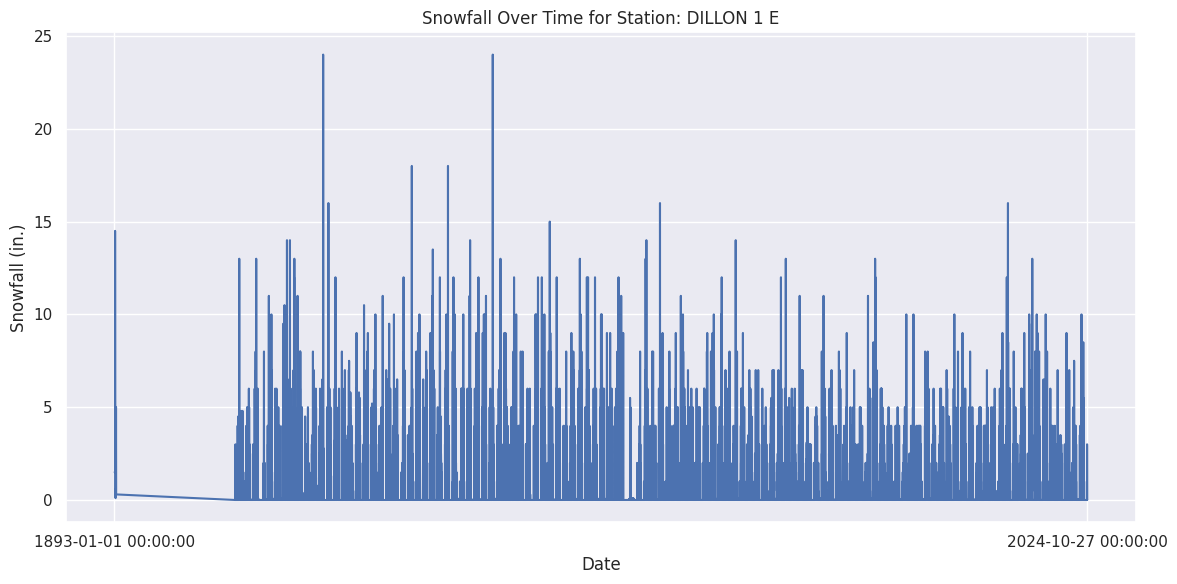

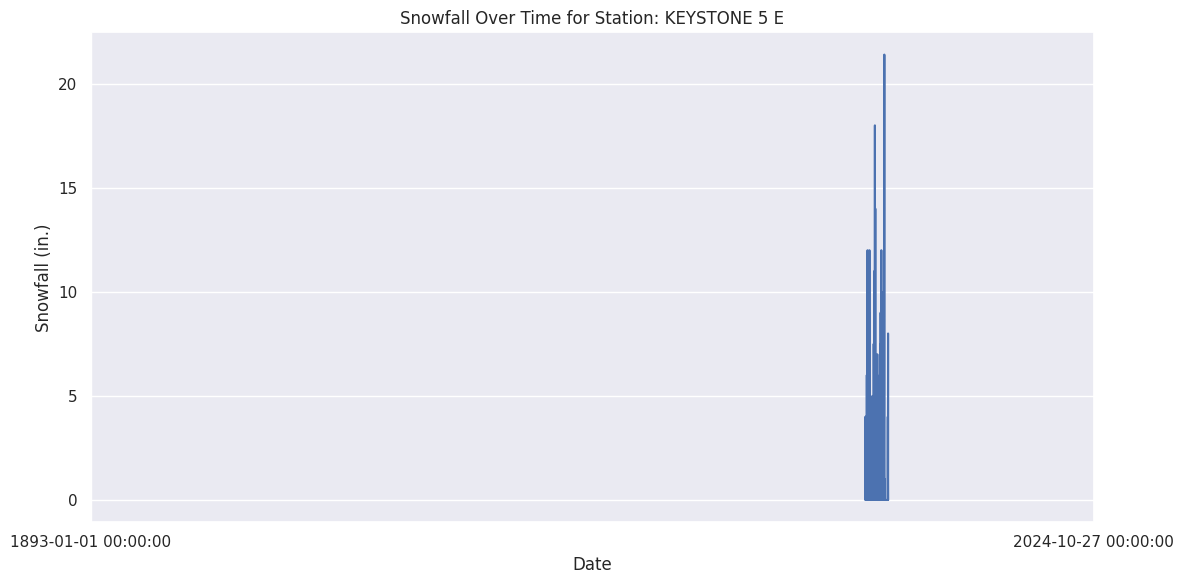

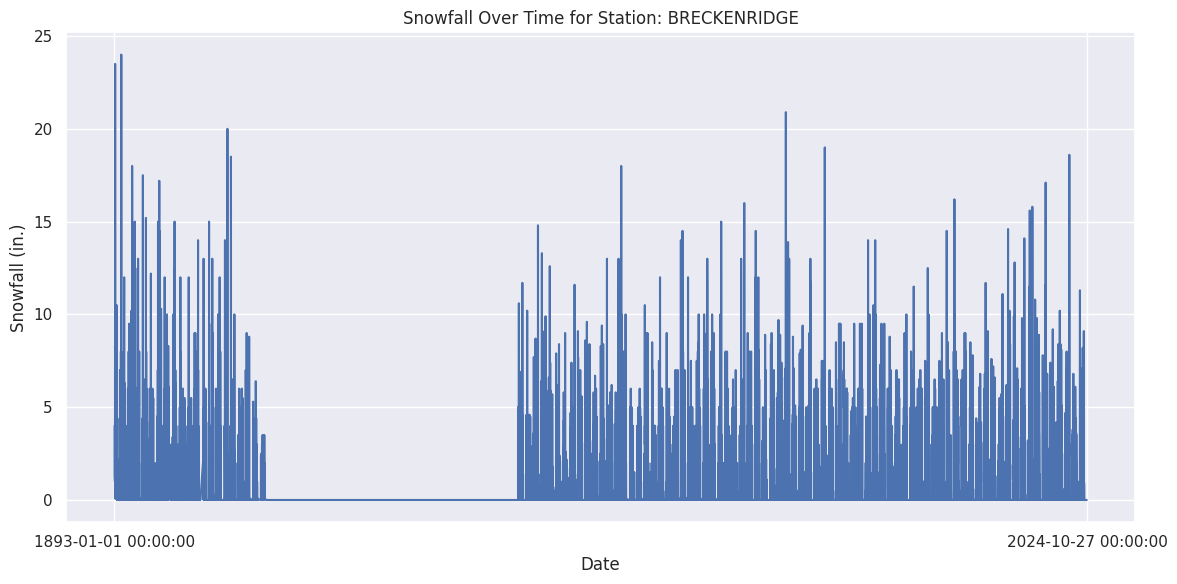

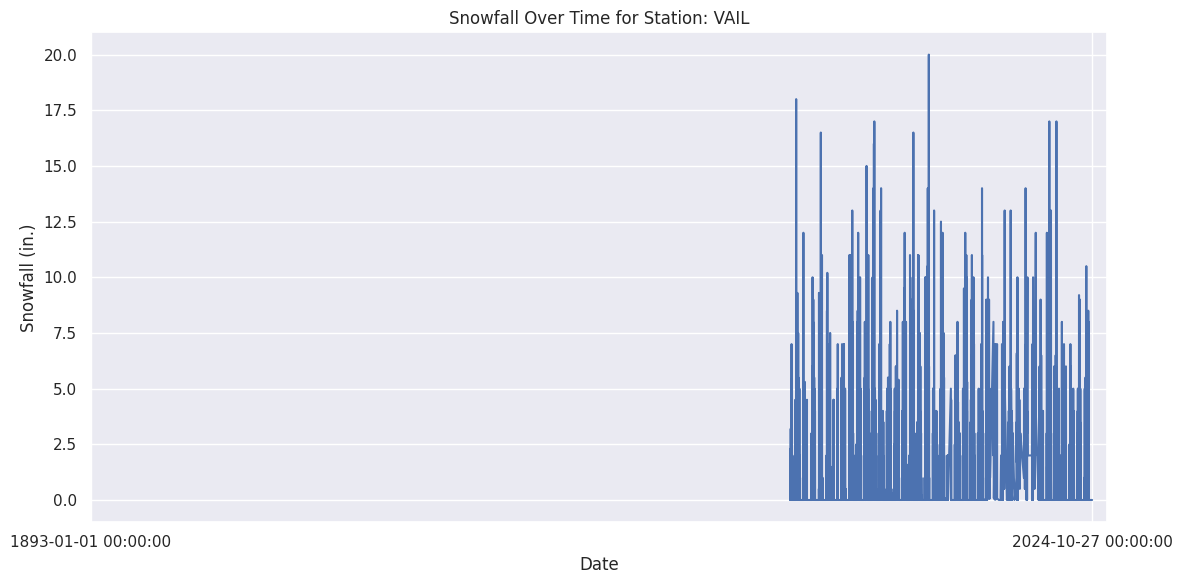

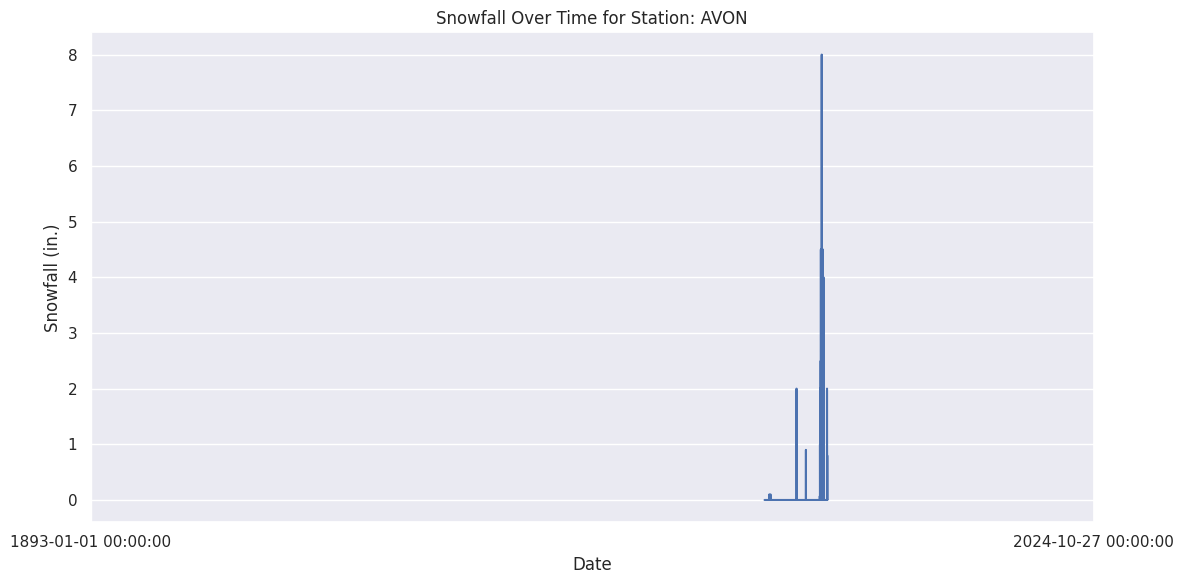

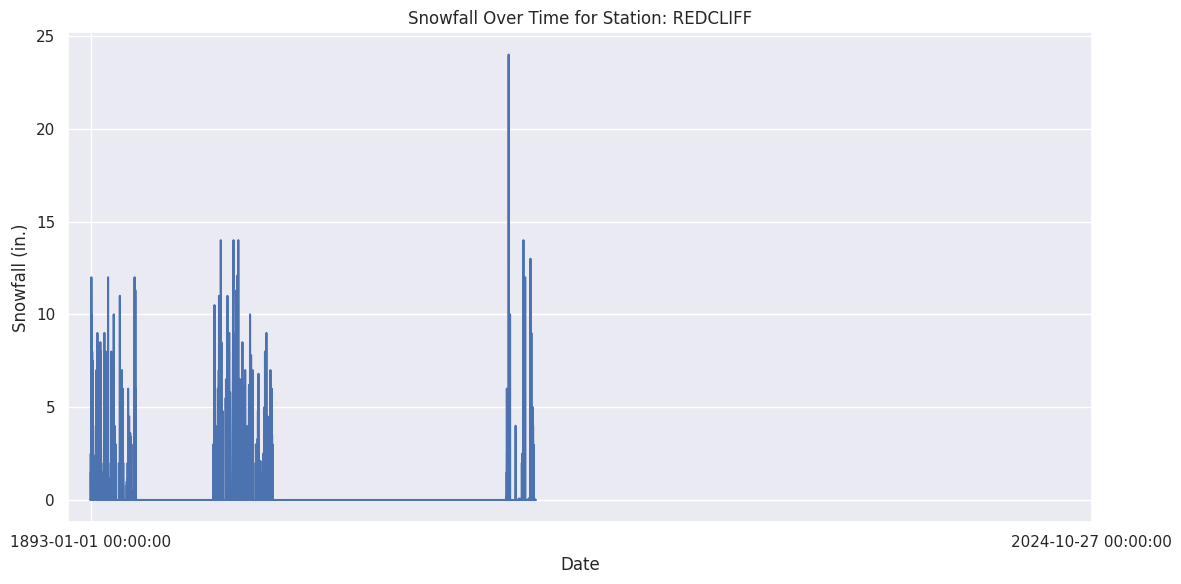

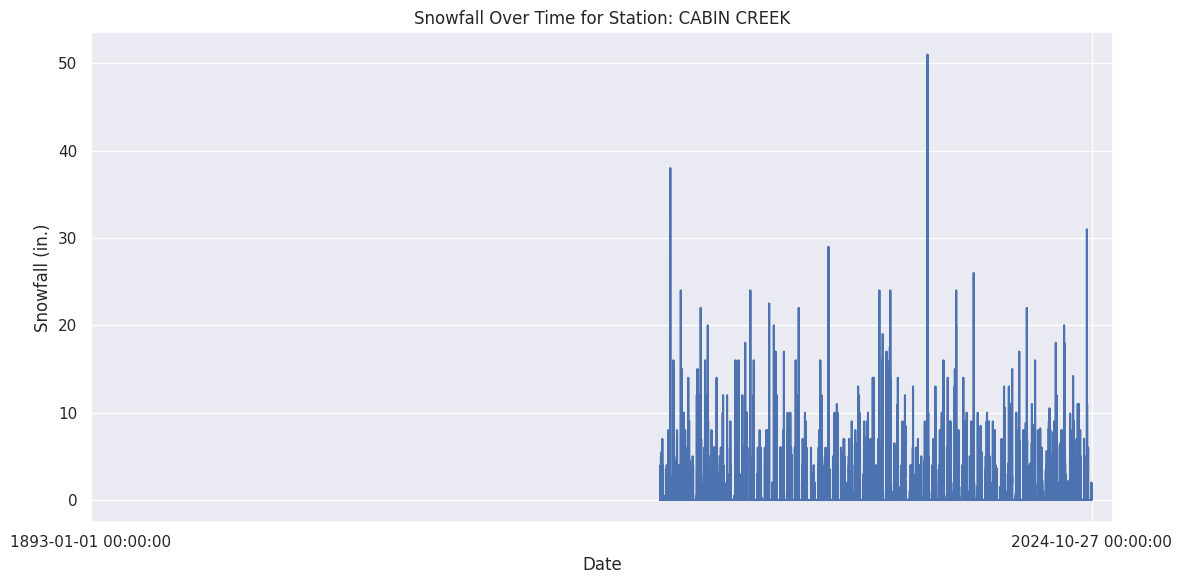

In [ ]:
combined_dataframe['date'] = pd.to_datetime(combined_dataframe['date'])
earliest_date = combined_dataframe['date'].min()
latest_date = combined_dataframe['date'].max()
sns.set_theme(font_scale=2.0)

# Loop through each station and create a separate line plot
for station in combined_dataframe['station_name'].unique():
    station_data = combined_dataframe[combined_dataframe['station_name'] == station]
    plt.figure(figsize=(12, 6))
    ax = sns.lineplot(data=station_data, x='date', y='converted_snowfall')
    plt.xlabel('Date')
    plt.ylabel('Snowfall (in.)')
    plt.title(f'Snowfall Over Time for Station: {station}')
    xticks = ax.get_xticks()
    xticks = [earliest_date, latest_date]
    ax.set_xticks(xticks)
    ax.set_xticklabels([earliest_date, latest_date])
    plt.tight_layout()
    plt.show()

When deciding how to handle the missing records at each station we must consider the method by which we are aggregating snowfall. As we are using a simple mean, populating the missing records with an average of the other stations would serve no purpose. Performing imputation using methods such as knn would unduly weight the measurements recorded at stations nearer the center of the area of interest. Additionally there are long periods for which there are not enough active stations for knn to produce a reasonable estimate. One last point to consider is the shear variance of measurements between stations in the area for a given day. These stations are packed into a relatively small area from a meteorological perspective in part due to the wide variation in weather experienced in the area. There are days for which most stations record trace measures while one will receive several inches of snow. Due to these factors we are making the decision to drop the missing records from the aggregations. There is no method to impute a reasonable value without significantly skewing the results, and the averaging of measures across active stations is the standard method of dealing with the uneven distribution of snowfall (NOAA, 2021).

In [ ]:
# remove truly missing values and narrow to columns of interest
combined_dataframe = combined_dataframe.dropna(subset=['converted_snowfall'])
columns_of_interest = combined_dataframe[['date', 'station_name', 'converted_snowfall']]
columns_of_interest.set_index('date', inplace=True)

# Aggregate measures into summit county total
blue_river_basin_snowfall = columns_of_interest.groupby('date')[["converted_snowfall"]].mean().reset_index()

# Aggregate to monthly level
monthly_snowfall = blue_river_basin_snowfall.groupby(pd.Grouper(key='date', freq='ME')).sum().reset_index()
monthly_snowfall.set_index('date', inplace=True)

# Data Analysis

Daily snowfall records exhibit a high degree of variance due to the nature of weather. In order to better understand long term trends we will be aggregating snowfall at the monthly level to cut down on the noise produced by daily data. Given this data is the definition of seasonal, we will conduct an STL decomposition to separate the seasonal component of the data. Doing so reveals an overall flat trend which runs counter to expectations given the decreasing trend in snowfall in the Upper Colorado Basin discussed earlier. Even if we limit our focus to the period tracked in the *Climate Change in Colorado* report there is no apparent long term trend. The residuals of the decomposition are consistent with white noise and we can therefore be confident in the analytic value of the decomposition.

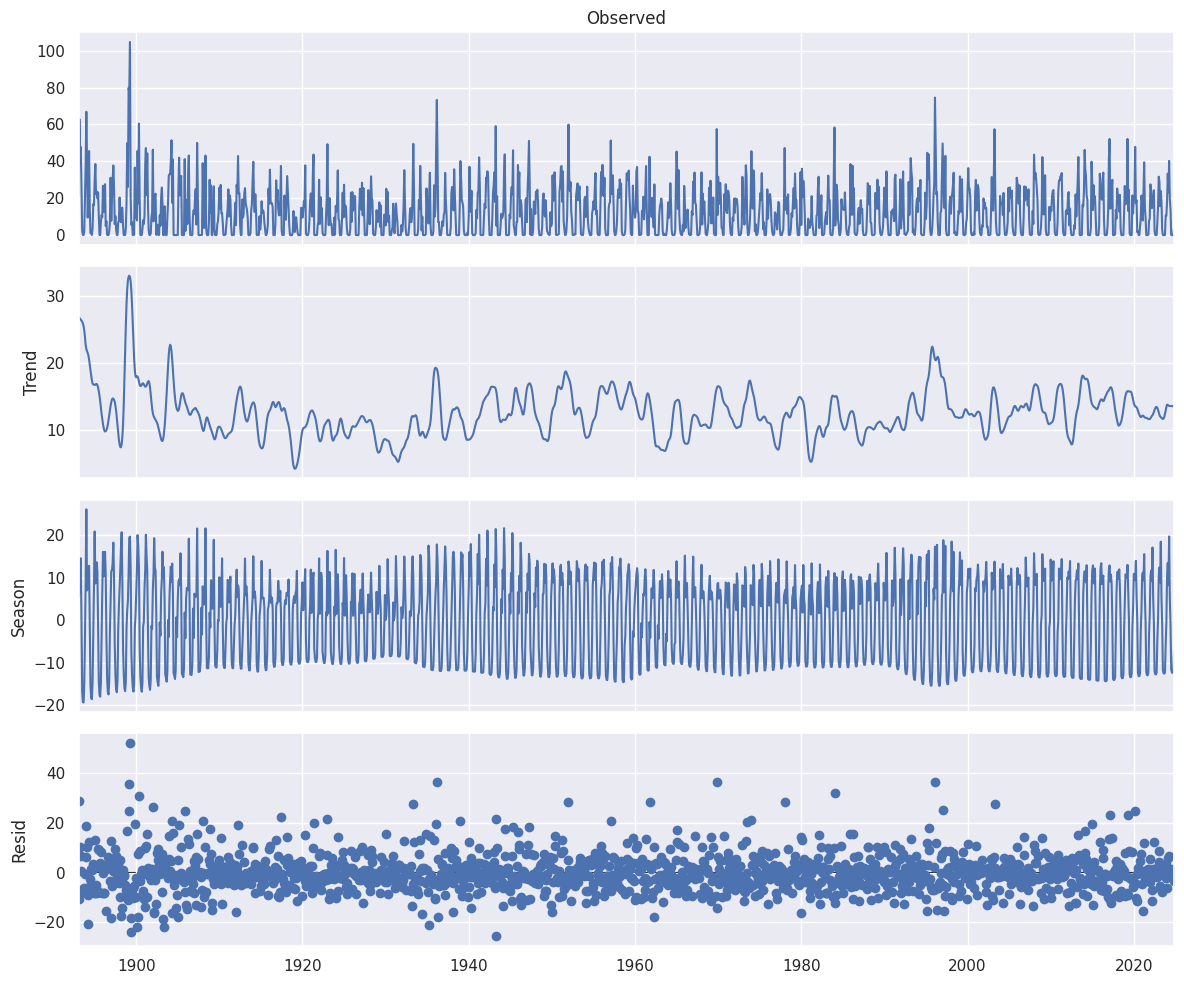

In [ ]:
from statsmodels.tsa.seasonal import STL

decompose_snowfall = STL(monthly_snowfall, seasonal=11, trend_deg = 0)
res = decompose_snowfall.fit()
fig = res.plot()
fig.set_size_inches(12, 10)
plt.tight_layout()

To provide a better visualization of the flat trend we can overlay a linear regression on the trend component of our decomposition. Doing so generates a flat regression even in spite of the high variance observed at the beginning of the period, confirming our initial observation.

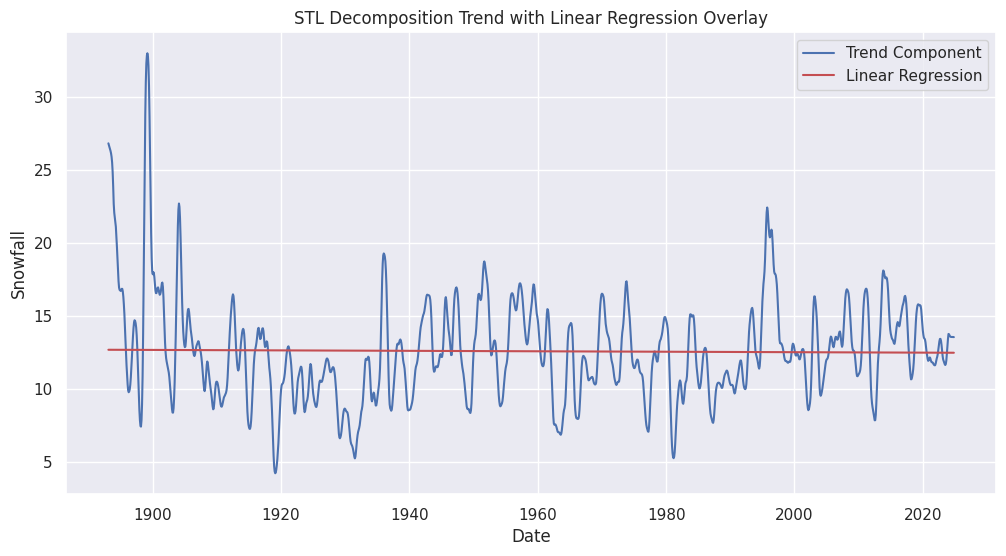

In [ ]:
# Calculate linear regression for the trend component
x = np.arange(len(res.trend))
y = res.trend.values
slope, intercept = np.polyfit(x, y, 1)

# Plot the trend component
plt.figure(figsize=(12, 6))
sns.lineplot(x=res.trend.index, y=res.trend.values, label='Trend Component')

# Overlay the linear regression line
plt.plot(res.trend.index, intercept + slope * x, 'r', label='Linear Regression')

plt.xlabel('Date')
plt.ylabel('Snowfall')
plt.title('STL Decomposition Trend with Linear Regression Overlay')
plt.legend()
plt.show()


Considering the scale of each of the components, in particular the trend and residual components, it is possible there is additional information in the residual component which could impact our conclusion. Upon combining the trend and residuals it is clear the flat nature of the trend observed previously is not influenced by the residuals, which is to be expected of a decomposition.

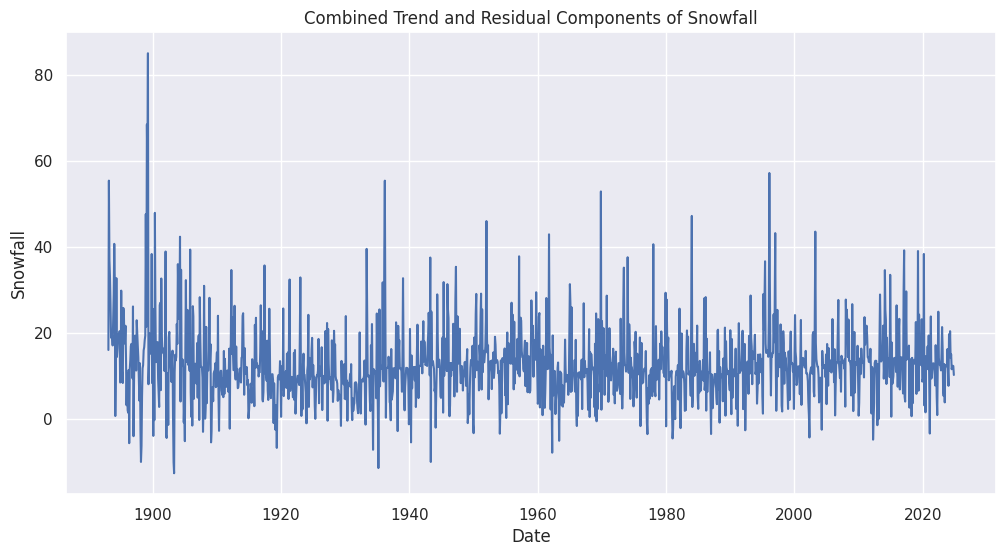

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(res.trend + res.resid)
plt.xlabel('Date')
plt.ylabel('Snowfall')
plt.title('Combined Trend and Residual Components of Snowfall')
plt.show()


# Conclusion

In this analysis we attempted to discover if there was a decreasing trend in snowfall in the Blue River Basin. The basin is of particular interest as it feeds some of the largest reservoirs in the Denver area in addition to being home to some of the most popular ski resorts in the world which provide tax revenue and jobs to the area. We tracked snowfall data from weather stations in and around the Blue River Basin and had records stretching back to the late 1800s. With data stretching back to the beginning of the industrial era we can have confidence that any changes between pre-industrial and modern snowfall totals would be evident. Upon performing an STL decomposition we were able to conclude the snowfall trend has been flat over the period of record, running counter to the decreasing trend across the wider Colorado Basin.

The flat trend in snowfall should be comforting for Denver residents as well as winter sports fans. It seems in spite of the general warming trend of the planet and decreasing precipitation over the Upper Colorado Basin, snowfall patterns have been largely unaffected in the area observed. The goal of this study was to demonstrate the importance of narrowing the scope of climate change analysis to determine the risks individual communities face. If one were to use only the macro trends for the region they would incorrectly conclude that Denver faces a more immediate threat to its water supply than it actually does. Such misguided conclusions, expanded and compounded across the country, have the potential to lead to policy decisions on infrastructure that result in a misallocation of resources to communities that are not currently at serious risk. While this analysis focussed on only one basin supplying water to a single city, it highlights the need for more localized analysis when attempting to determine the correct course of action to mitigate the consequences of climate change.


# Sources

Adams, J. (2021, June 29). Where does your water come from?. Denver Water. https://www.denverwater.org/tap/where-does-your-water-come?size=n_21_n

Bolinger, R.A., J.J. Lukas, R.S. Schumacher, and P.E. Goble (2024, January 8), 2024: Climate Change in Colorado, 3rd edition. Colorado State University, https://doi.org/10.25675/10217/237323.

NOAA's National Weather Service. (2021, December 31). Precipitation measurements. National Weather Service. https://www.weather.gov/abrfc/map

Ware, E. C., Schultz, D. M., Brooks, H. E., Roebber, P. J., & Bruening, S. L. (2005, May 26). Improving Snowfall Forecasting by Accounting for the Climatological Variability of Snow Density. Weather And Forecasting. https://www.nssl.noaa.gov/users/brooks/public_html/papers/wareetal2006.pdf

Data from Colorado State University's Colorado Climate Center https://climate.colostate.edu/data_access_new.html